In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [3]:
img_path = "turtle.jpg"   # <- change if needed
bgr = cv2.imread(img_path)
if bgr is None:
    raise FileNotFoundError(f"Couldn't read: {img_path}")
img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)   # work in RGB
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print("[0] Loaded image:", img.shape)


[0] Loaded image: (150, 200, 3)


In [4]:
def norm_hist(one_channel, bins=256):
    h = cv2.calcHist([one_channel], [0], None, [bins], [0, 256]).ravel()
    return h / (h.sum() + 1e-9)

R, G, B = cv2.split(img)


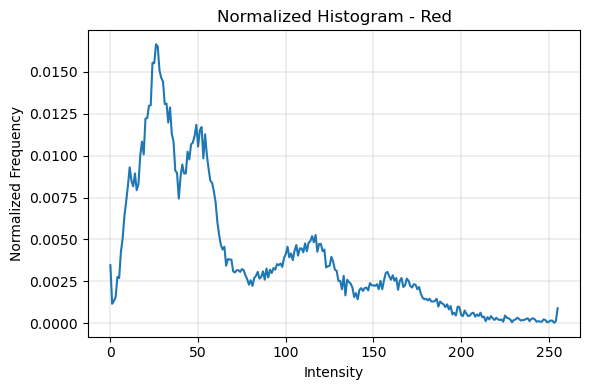

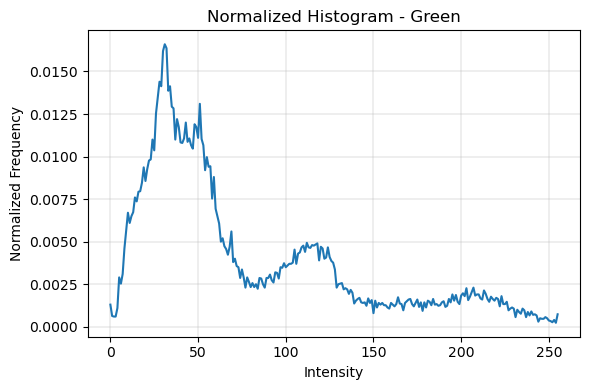

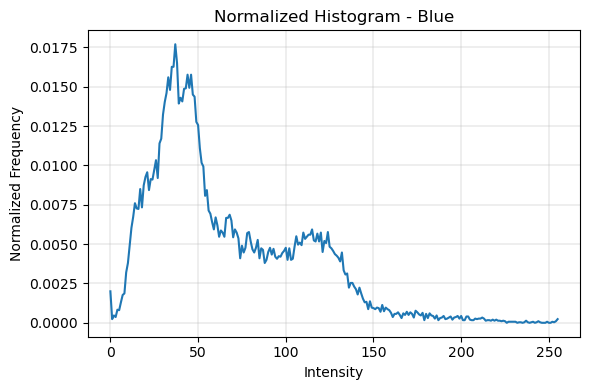

[2a] Shown individual normalized RGB histograms.


In [5]:
for data, name in [(R,"Red"), (G,"Green"), (B,"Blue")]:
    h = norm_hist(data)
    x = np.arange(256)
    plt.figure(figsize=(6,4))
    plt.plot(x, h, linewidth=1.5)
    plt.title(f"Normalized Histogram - {name}")
    plt.xlabel("Intensity"); plt.ylabel("Normalized Frequency")
    plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()
print("[2a] Shown individual normalized RGB histograms.")

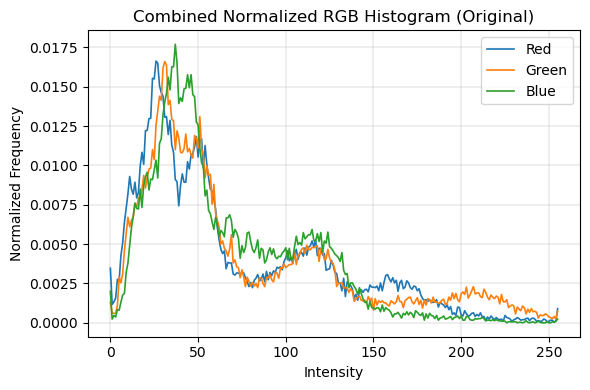

[2b] Shown combined normalized RGB histogram.


In [6]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(256), norm_hist(R), label="Red",   linewidth=1.2)
plt.plot(np.arange(256), norm_hist(G), label="Green", linewidth=1.2)
plt.plot(np.arange(256), norm_hist(B), label="Blue",  linewidth=1.2)
plt.title("Combined Normalized RGB Histogram (Original)")
plt.xlabel("Intensity"); plt.ylabel("Normalized Frequency")
plt.grid(True, linewidth=0.3); plt.legend(); plt.tight_layout(); plt.show()
print("[2b] Shown combined normalized RGB histogram.")


In [7]:
c = 255.0 / np.log1p(255.0)
img_log = np.clip(c * np.log1p(img.astype(np.float32)), 0, 255).astype(np.uint8)
print("[3.1] Logarithmic transformation done.")

[3.1] Logarithmic transformation done.


In [8]:
def gamma_corr(rgb, gamma):
    lut = np.array([(i/255.0)**gamma * 255.0 for i in range(256)]).astype(np.uint8)
    return cv2.LUT(rgb, lut)

img_gamma_05 = gamma_corr(img, 0.5)  # brighter
img_gamma_18 = gamma_corr(img, 1.8)  # darker
print("[3.2] Gamma correction done: γ=0.5 and γ=1.8.")

[3.2] Gamma correction done: γ=0.5 and γ=1.8.


In [9]:
def contrast_stretch(rgb, p_low=2.0, p_high=98.0):
    r,g,b = cv2.split(rgb.astype(np.float32))
    outs = []
    mins = []
    maxs = []
    for ch in [r,g,b]:
        lo = np.percentile(ch, p_low)
        hi = np.percentile(ch, p_high)
        mins.append(lo); maxs.append(hi)
        scale = 255.0 / (hi - lo) if hi > lo else 1.0
        ch2 = np.clip((ch - lo) * scale, 0, 255).astype(np.uint8)
        outs.append(ch2)
    return cv2.merge(outs), mins, maxs

img_cs, mins, maxs = contrast_stretch(img, 2, 98)
print(f"[3.3] Contrast stretching done.\n      mins={mins}\n      maxs={maxs}")

[3.3] Contrast stretching done.
      mins=[np.float32(7.0), np.float32(9.0), np.float32(11.0)]
      maxs=[np.float32(195.0), np.float32(226.0), np.float32(168.02148)]


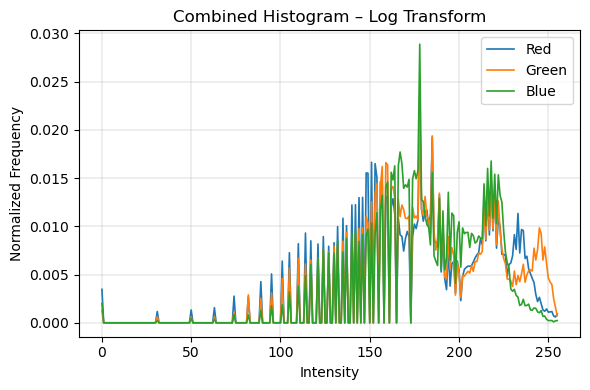

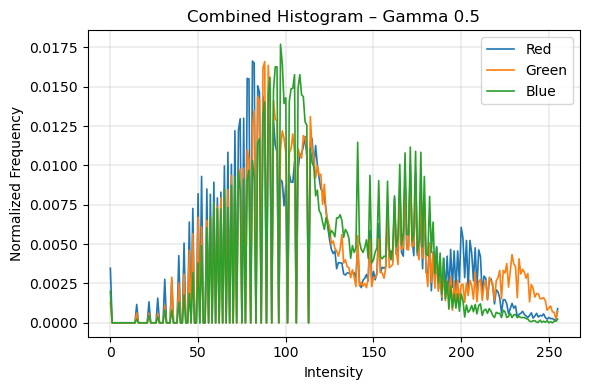

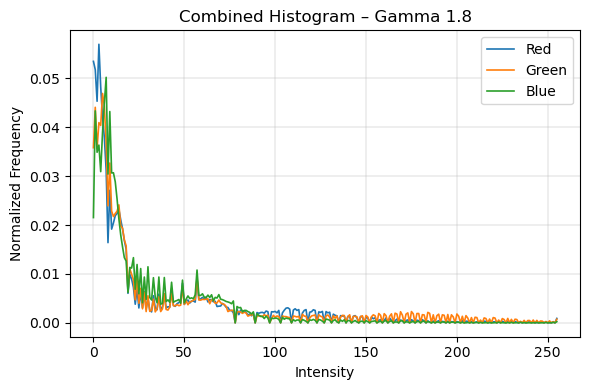

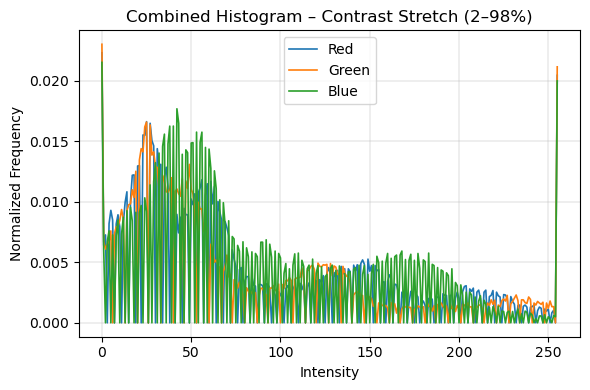

[3] Shown histograms for all intensity transforms.


In [10]:
def show_combined_hist(rgb, title):
    r,g,b = cv2.split(rgb)
    x = np.arange(256)
    plt.figure(figsize=(6,4))
    plt.plot(x, norm_hist(r), label="Red", linewidth=1.2)
    plt.plot(x, norm_hist(g), label="Green", linewidth=1.2)
    plt.plot(x, norm_hist(b), label="Blue", linewidth=1.2)
    plt.title(title); plt.xlabel("Intensity"); plt.ylabel("Normalized Frequency")
    plt.grid(True, linewidth=0.3); plt.legend(); plt.tight_layout(); plt.show()

show_combined_hist(img_log,      "Combined Histogram – Log Transform")
show_combined_hist(img_gamma_05, "Combined Histogram – Gamma 0.5")
show_combined_hist(img_gamma_18, "Combined Histogram – Gamma 1.8")
show_combined_hist(img_cs,       "Combined Histogram – Contrast Stretch (2–98%)")
print("[3] Shown histograms for all intensity transforms.")

In [11]:
r_eq = cv2.equalizeHist(cv2.split(img)[0])
g_eq = cv2.equalizeHist(cv2.split(img)[1])
b_eq = cv2.equalizeHist(cv2.split(img)[2])
img_eq_rgb = cv2.merge([r_eq, g_eq, b_eq])
print("[4.1] Equalized R, G, B channels separately.")


[4.1] Equalized R, G, B channels separately.


In [12]:
ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
y, cr, cb = cv2.split(ycrcb)
y_eq = cv2.equalizeHist(y)
img_eq_y = cv2.cvtColor(cv2.merge([y_eq, cr, cb]), cv2.COLOR_YCrCb2RGB)
print("[4.2] Equalized Y (luminance) in YCrCb, colors preserved.")

[4.2] Equalized Y (luminance) in YCrCb, colors preserved.


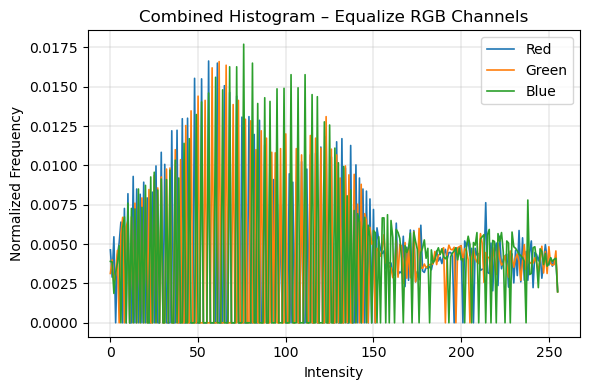

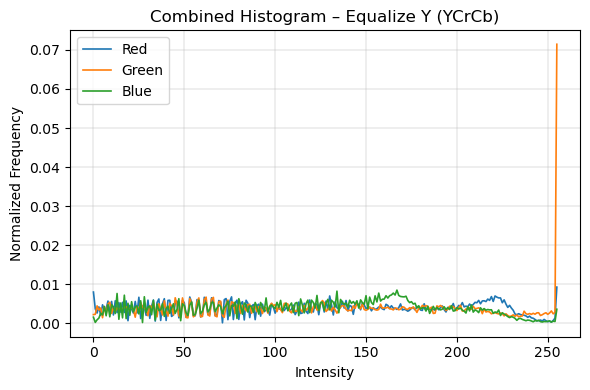

In [13]:
# (Optional) show combined hists for the equalized results
show_combined_hist(img_eq_rgb, "Combined Histogram – Equalize RGB Channels")
show_combined_hist(img_eq_y,   "Combined Histogram – Equalize Y (YCrCb)")

In [14]:
_, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Adaptive thresholding (mean & gaussian)
th_mean  = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY, 15, 10)
th_gauss = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 15, 10)
print("[5] Otsu + Adaptive (mean & gaussian) thresholding done.")

[5] Otsu + Adaptive (mean & gaussian) thresholding done.


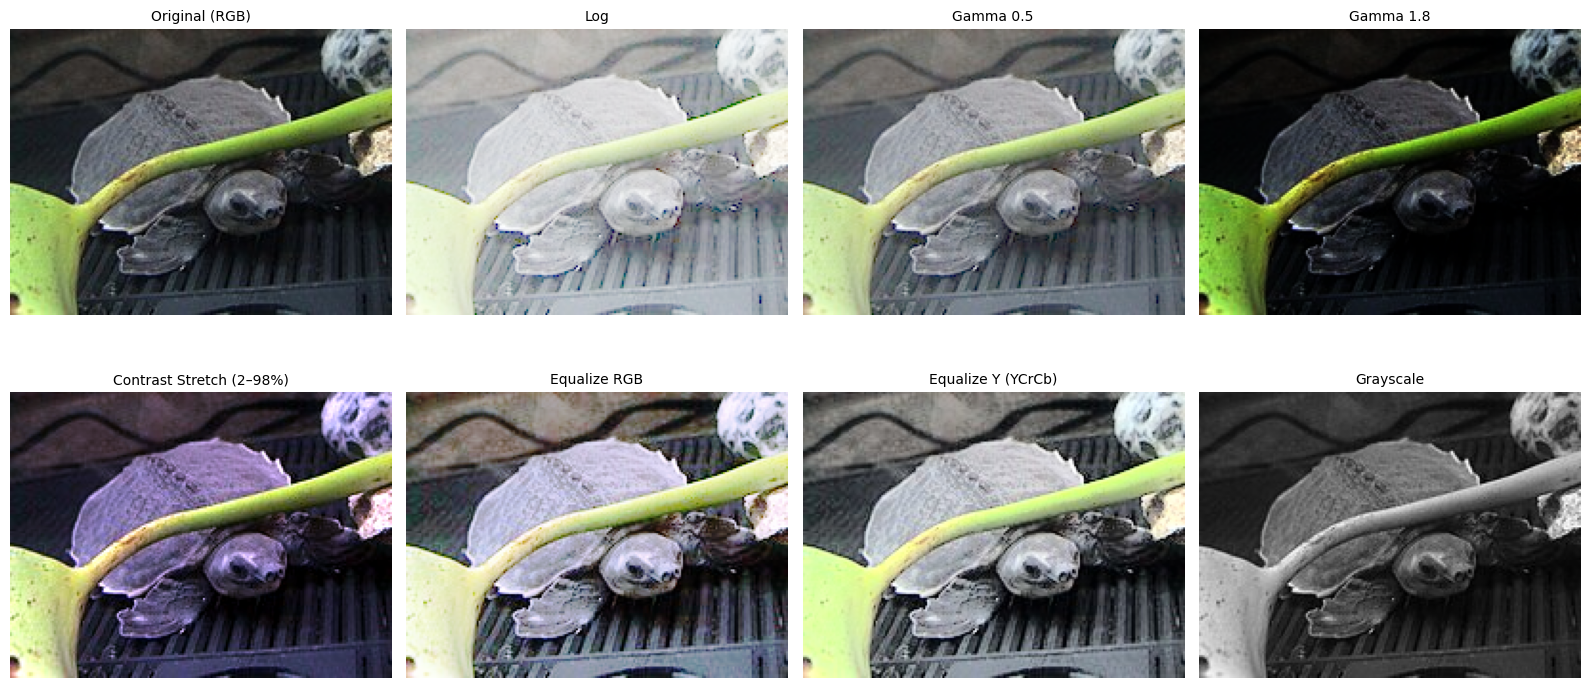

[6A] Shown original vs transformed images side-by-side.


In [15]:
imgs = [img, img_log, img_gamma_05, img_gamma_18,
        img_cs, img_eq_rgb, img_eq_y, gray]
titles = ["Original (RGB)", "Log", "Gamma 0.5", "Gamma 1.8",
          "Contrast Stretch (2–98%)", "Equalize RGB", "Equalize Y (YCrCb)", "Grayscale"]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for ax, im, t in zip(axes.ravel(), imgs, titles):
    ax.imshow(im if im.ndim == 3 else im, cmap=None if im.ndim == 3 else "gray")
    ax.set_title(t, fontsize=10); ax.axis("off")
plt.tight_layout(); plt.show()
print("[6A] Shown original vs transformed images side-by-side.")

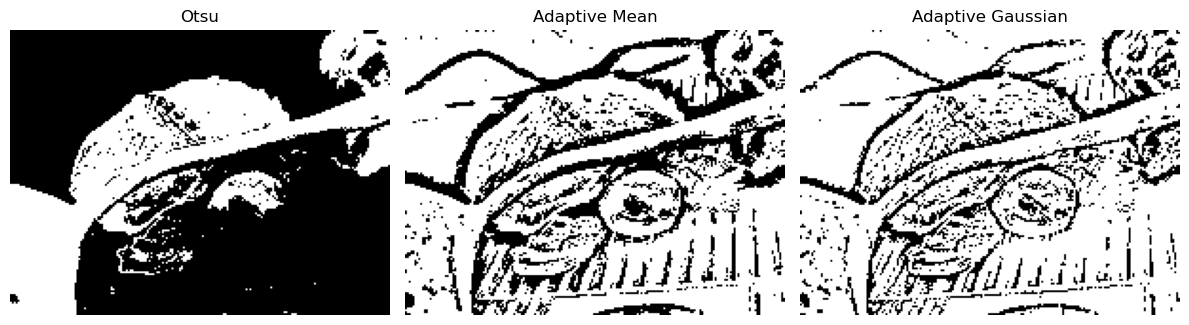

[6B] Shown thresholding comparison.


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, im, t in zip(axes, [th_otsu, th_mean, th_gauss],
                     ["Otsu", "Adaptive Mean", "Adaptive Gaussian"]):
    ax.imshow(im, cmap="gray"); ax.set_title(t); ax.axis("off")
plt.tight_layout(); plt.show()
print("[6B] Shown thresholding comparison.")